In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

#### Reflect Tables into SQL Alchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

C:\Users\alexi\AppData\Local\Temp\ipykernel_21284\2248493801.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [11]:
# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
Measurement = Base.classes.measurement
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)

2017-08-23


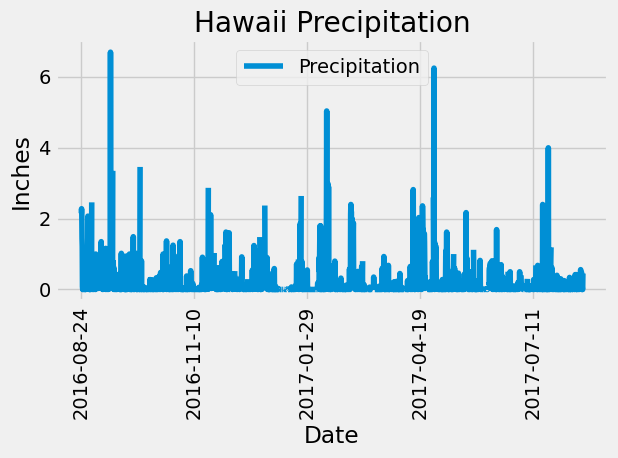

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


from datetime import datetime, timedelta
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date_obj = datetime.strptime(last_date, "%Y-%m-%d")
one_year_ago = last_date_obj - timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df = df.sort_values(by=['Date'])
ax = df.plot(x='Date', y='Precipitation', rot=90)
ax.set_title('Hawaii Precipitation')
ax.set_ylabel('Inches')
plt.tight_layout()
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_data = pd.read_csv('hawaii_measurements.csv')
summary_stats = precip_data['prcp'].describe()
print(summary_stats)

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64


### Exploratory Station Analysis

In [47]:
# Design a query to find the most active stations
station_counts = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()

# Print the station and their counts in descending order
for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()[0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .all()
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"For the most active station {most_active_station_id}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

For the most active station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


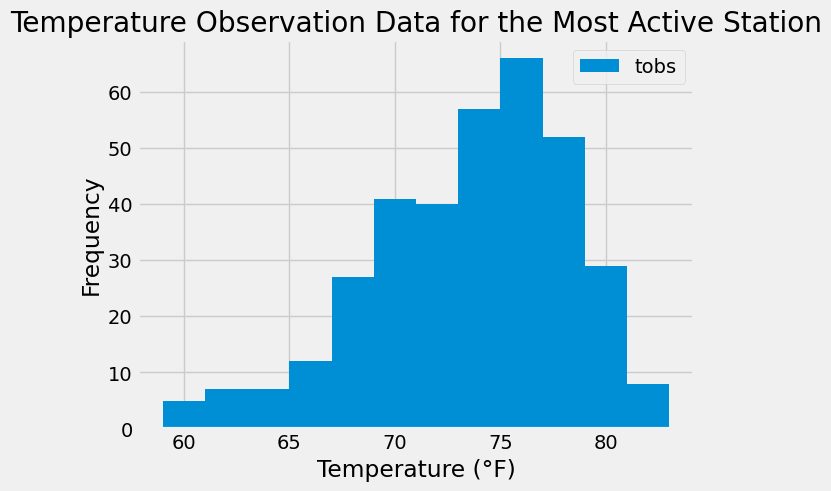

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date_obj = datetime.strptime(last_date, "%Y-%m-%d")
one_year_ago = last_date_obj - timedelta(days=365)
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago)\
    .all()
temperatures = [result[0] for result in temperature_data]
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Most Active Station')
plt.legend()
plt.show()

### Close Session

In [50]:
# Close Session
session.close()